# Training an LSTM network to detect punches during shadow boxing
During this project I will be training a Long Short Term Memory (LSTM) network to detect which punch is being thrown during shadow boxing. This project was inspired by a talk given by [Zack Akil](https://github.com/ZackAkil) about using Google's VideoIntelligence API to analyse a penalty shootout, as well as [Anudeep Ayinaparthi](https://github.com/anudeepayina/CricketTracker)'s cricket shot classifier.

### LSTM vs RNN
An LSTM is a type of recurrent neural network (RNN), which is able to learn from longer sequences of input data than a regular RNN, without "forgetting" information from the earlier datapoints in the sequence. This problem is known as ['vanishing gradients'](https://towardsdatascience.com/the-exploding-and-vanishing-gradients-problem-in-time-series-6b87d558d22), and occurs due to the way RNNs are trained, where as gradients are passed back through the network during the backpropagation phase, they get smaller and smaller due to the chain rule and eventually become so small that they can not be used to update the weights and biases of the network (see also: [exploding gradients](https://towardsdatascience.com/the-exploding-and-vanishing-gradients-problem-in-time-series-6b87d558d22)). 

An LSTM network solves this problem through the a combination of 'forget gates', 'input gates' and 'output gates'. This combination of gates in an LSTM cell allows only the most salient signal information to be passed through the network, by using the *sigmoid* and *tanh* functions to compress information between the range of 0 and 1. This [article](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) does a great job of explaining how these gates combine to achieve this.

### Setup
In this project we will be using Google Cloud Platform's *VideoIntelligence* API to analyse input videos, so we will need to set up our Google Cloud Platform account accordingly. A great guide for doing this can be found [here](https://github.com/google/making_with_ml/blob/master/sports_ai/Sports_AI_Analysis.ipynb)

### Importing libraries


In [1]:
import csv
import json
import math
import os
import sys

import pandas as pd
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

from google.cloud import videointelligence_v1 as videointelligence
from google.oauth2 import service_account

Set up GCP environment variables

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/home/test/Downloads/op-boxing-analysis2-29e9638655b8.json'

This function is taken from VideoIntelligence API documentation, found [here]( https://cloud.google.com/video-intelligence/docs/people-detection)

In [3]:
def detect_person(gcs_uri="gs://YOUR_BUCKET_ID/path/to/your/video.mp4", output_uri=""):
    """Detects people in a video."""
    client = videointelligence.VideoIntelligenceServiceClient()

    # Configure the request
    config = videointelligence.types.PersonDetectionConfig(
        include_bounding_boxes=True,
        include_attributes=True,
        include_pose_landmarks=True,
    )

    context = videointelligence.types.VideoContext(person_detection_config=config)

    # Start the asynchronous request
    operation = client.annotate_video(
        request={
            "features": [videointelligence.Feature.PERSON_DETECTION],
            "input_uri": gcs_uri,
            "output_uri": output_uri,
            "video_context": context,
        }
    )

    print("\nProcessing video for person detection annotations.")
    result = operation.result(timeout=300)

    print("\nFinished processing.\n")

    # Retrieve the first result, because a single video was processed.
    annotation_result = result.annotation_results[0]

    for annotation in annotation_result.person_detection_annotations:
        print("Person detected:")
        for track in annotation.tracks:
            print(
                "Segment: {}s to {}s".format(
                    track.segment.start_time_offset.seconds
                    + track.segment.start_time_offset.microseconds / 1e6,
                    track.segment.end_time_offset.seconds
                    + track.segment.end_time_offset.microseconds / 1e6,
                )
            )

            # Each segment includes timestamped objects that include
            # characteristics - -e.g.clothes, posture of the person detected.
            # Grab the first timestamped object
            timestamped_object = track.timestamped_objects[0]
            box = timestamped_object.normalized_bounding_box
            print("Bounding box:")
            print("\tleft  : {}".format(box.left))
            print("\ttop   : {}".format(box.top))
            print("\tright : {}".format(box.right))
            print("\tbottom: {}".format(box.bottom))

            # Attributes include unique pieces of clothing,
            # poses, or hair color.
            print("Attributes:")
            for attribute in timestamped_object.attributes:
                print(
                    "\t{}:{} {}".format(
                        attribute.name, attribute.value, attribute.confidence
                    )
                )

            # Landmarks in person detection include body parts such as
            # left_shoulder, right_ear, and right_ankle
            print("Landmarks:")
            for landmark in timestamped_object.landmarks:
                print(
                    "\t{}: {} (x={}, y={})".format(
                        landmark.name,
                        landmark.confidence,
                        landmark.point.x,  # Normalized vertex
                        landmark.point.y,  # Normalized vertex
                    )
                )

    return annotation_result


Here we loop through all the videos in the GCP bucket, calling the *detect_person* function on each and storing the results in another GCP bucket

In [35]:
for i in range(11,37):
    input_uri = 'gs://op-boxing-analysis2/Photos(1)/jab%i.mp4' %i
    output_uri = "gs://op-boxing-analysis2/jab%i.json" %i
    results = detect_person(input_uri, output_uri)


1
2
3
4
5

Processing video for person detection annotations.

Finished processing.

Person detected:
Segment: 0.0s to 2.1021s
Bounding box:
	left  : 0.37968748807907104
	top   : 0.11666666716337204
	right : 0.614062488079071
	bottom: 0.9768518805503845
Attributes:
	UpperCloth:Yellow 0.00136940972879529
	UpperCloth:White 0.008959038183093071
	UpperCloth:TankTop 0.09106609970331192
	UpperCloth:T-Shirt 0.4954766631126404
	UpperCloth:Sweater 0.006086437962949276
	UpperCloth:Suit 0.0009574367431923747
	UpperCloth:Striped 0.016338028013706207
	UpperCloth:Spotted 0.0037772164214402437
	UpperCloth:ShortSleeve 0.8089791536331177
	UpperCloth:Shirt 0.014098971150815487
	UpperCloth:Red 0.0025303324218839407
	UpperCloth:Purple 0.016119325533509254
	UpperCloth:Plain 0.7755048871040344
	UpperCloth:Plaid 0.00010525513789616525
	UpperCloth:Orange 6.696581840515137e-05
	UpperCloth:NoSleeve 0.16728104650974274
	UpperCloth:MultiColor 0.03637025132775307
	UpperCloth:LongSleeve 0.06983117759227753
	UpperCl

5

Processing video for person detection annotations.

Finished processing.

Person detected:
Segment: 0.0s to 1.9019s
Bounding box:
	left  : 0.3817708194255829
	top   : 0.1101851835846901
	right : 0.6223958134651184
	bottom: 0.9814814925193787
Attributes:
	UpperCloth:Yellow 0.0013960087671875954
	UpperCloth:White 0.006268993951380253
	UpperCloth:TankTop 0.04267559200525284
	UpperCloth:T-Shirt 0.6915420889854431
	UpperCloth:Sweater 0.0027539576403796673
	UpperCloth:Suit 0.00014266805374063551
	UpperCloth:Striped 0.018494179472327232
	UpperCloth:Spotted 0.0024411026388406754
	UpperCloth:ShortSleeve 0.8885910511016846
	UpperCloth:Shirt 0.011336442083120346
	UpperCloth:Red 0.002005624119192362
	UpperCloth:Purple 0.008540158160030842
	UpperCloth:Plain 0.674766480922699
	UpperCloth:Plaid 0.0001460807688999921
	UpperCloth:Orange 7.361597090493888e-05
	UpperCloth:NoSleeve 0.08796790987253189
	UpperCloth:MultiColor 0.036943867802619934
	UpperCloth:LongSleeve 0.033616892993450165
	UpperCloth:Ja

5

Processing video for person detection annotations.

Finished processing.

Person detected:
Segment: 0.0s to 1.7017s
Bounding box:
	left  : 0.3864583373069763
	top   : 0.0833333358168602
	right : 0.6463541984558105
	bottom: 0.979629635810852
Attributes:
	UpperCloth:Yellow 0.0014484290732070804
	UpperCloth:White 0.007063424214720726
	UpperCloth:TankTop 0.041741032153367996
	UpperCloth:T-Shirt 0.7013198137283325
	UpperCloth:Sweater 0.0019674389623105526
	UpperCloth:Suit 8.892144978744909e-05
	UpperCloth:Striped 0.021594183519482613
	UpperCloth:Spotted 0.0024769508745521307
	UpperCloth:ShortSleeve 0.8991701602935791
	UpperCloth:Shirt 0.012179160490632057
	UpperCloth:Red 0.003032139502465725
	UpperCloth:Purple 0.010984858497977257
	UpperCloth:Plain 0.6796562671661377
	UpperCloth:Plaid 0.00014762887440156192
	UpperCloth:Orange 0.00010910917626461014
	UpperCloth:NoSleeve 0.08223661035299301
	UpperCloth:MultiColor 0.04233622923493385
	UpperCloth:LongSleeve 0.024995051324367523
	UpperCloth:J

5

Processing video for person detection annotations.

Finished processing.

Person detected:
Segment: 0.0s to 2.1021s
Bounding box:
	left  : 0.40572917461395264
	top   : 0.09444444626569748
	right : 0.6656249761581421
	bottom: 0.9731481671333313
Attributes:
	UpperCloth:Yellow 0.001657197717577219
	UpperCloth:White 0.012062940746545792
	UpperCloth:TankTop 0.08017539232969284
	UpperCloth:T-Shirt 0.6668574810028076
	UpperCloth:Sweater 0.0014954276848584414
	UpperCloth:Suit 5.505580338649452e-05
	UpperCloth:Striped 0.017409969121217728
	UpperCloth:Spotted 0.001553818117827177
	UpperCloth:ShortSleeve 0.8658444285392761
	UpperCloth:Shirt 0.010356012731790543
	UpperCloth:Red 0.0027164032217115164
	UpperCloth:Purple 0.007530150935053825
	UpperCloth:Plain 0.7267069220542908
	UpperCloth:Plaid 7.817239384166896e-05
	UpperCloth:Orange 0.00010887272947002202
	UpperCloth:NoSleeve 0.1394573301076889
	UpperCloth:MultiColor 0.039160165935754776
	UpperCloth:LongSleeve 0.02082652412354946
	UpperCloth:Ja

5

Processing video for person detection annotations.

Finished processing.

Person detected:
Segment: 0.0s to 2.4024s
Bounding box:
	left  : 0.43177083134651184
	top   : 0.10370370000600815
	right : 0.6989583373069763
	bottom: 0.989814817905426
Attributes:
	UpperCloth:Yellow 0.0014668299118056893
	UpperCloth:White 0.009708831086754799
	UpperCloth:TankTop 0.08891431242227554
	UpperCloth:T-Shirt 0.6497679948806763
	UpperCloth:Sweater 0.001963659655302763
	UpperCloth:Suit 8.384702960029244e-05
	UpperCloth:Striped 0.018638521432876587
	UpperCloth:Spotted 0.0017956886440515518
	UpperCloth:ShortSleeve 0.8583779335021973
	UpperCloth:Shirt 0.012978002429008484
	UpperCloth:Red 0.0032466943375766277
	UpperCloth:Purple 0.009346245788037777
	UpperCloth:Plain 0.6980193853378296
	UpperCloth:Plaid 9.284558473154902e-05
	UpperCloth:Orange 0.00011365605314495042
	UpperCloth:NoSleeve 0.14857175946235657
	UpperCloth:MultiColor 0.040766775608062744
	UpperCloth:LongSleeve 0.02210231125354767
	UpperCloth:J

5

Processing video for person detection annotations.

Finished processing.

Person detected:
Segment: 0.0s to 1.3013s
Bounding box:
	left  : 0.4010416567325592
	top   : 0.07777778059244156
	right : 0.6526041626930237
	bottom: 0.9750000238418579
Attributes:
	UpperCloth:Yellow 0.0018247619736939669
	UpperCloth:White 0.01269085705280304
	UpperCloth:TankTop 0.02201925404369831
	UpperCloth:T-Shirt 0.7879782915115356
	UpperCloth:Sweater 0.0016762507148087025
	UpperCloth:Suit 2.117097938025836e-05
	UpperCloth:Striped 0.021381068974733353
	UpperCloth:Spotted 0.0015800677938386798
	UpperCloth:ShortSleeve 0.9161126613616943
	UpperCloth:Shirt 0.00962932500988245
	UpperCloth:Red 0.0025033347774297
	UpperCloth:Purple 0.004980453755706549
	UpperCloth:Plain 0.5373356342315674
	UpperCloth:Plaid 0.00018256873590871692
	UpperCloth:Orange 0.0001331238599959761
	UpperCloth:NoSleeve 0.053221315145492554
	UpperCloth:MultiColor 0.05296914279460907
	UpperCloth:LongSleeve 0.025924358516931534
	UpperCloth:Jack

5

Processing video for person detection annotations.

Finished processing.

Person detected:
Segment: 0.0s to 1.4014s
Bounding box:
	left  : 0.43281251192092896
	top   : 0.10833333432674408
	right : 0.7026041746139526
	bottom: 0.9870370626449585
Attributes:
	UpperCloth:Yellow 0.00217376253567636
	UpperCloth:White 0.015682166442275047
	UpperCloth:TankTop 0.07801636308431625
	UpperCloth:T-Shirt 0.640978991985321
	UpperCloth:Sweater 0.0017209945945069194
	UpperCloth:Suit 0.00019098276970908046
	UpperCloth:Striped 0.02209610305726528
	UpperCloth:Spotted 0.002004884649068117
	UpperCloth:ShortSleeve 0.8792017102241516
	UpperCloth:Shirt 0.018068499863147736
	UpperCloth:Red 0.0029680160805583
	UpperCloth:Purple 0.010870731435716152
	UpperCloth:Plain 0.7367657423019409
	UpperCloth:Plaid 0.00013107141421642154
	UpperCloth:Orange 0.00016824298654682934
	UpperCloth:NoSleeve 0.11670839041471481
	UpperCloth:MultiColor 0.04699582979083061
	UpperCloth:LongSleeve 0.022774700075387955
	UpperCloth:Jacke

Next, we copy all of the results files into our local *tmp* directory for processing

In [4]:
!gsutil cp "gs://op-boxing-analysis2/*.json" tmp




Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying gs://op-boxing-analysis2/jab1.json...
Copying gs://op-boxing-analysis2/jab11.json...                                  
Copying gs://op-boxing-analysis2/jab12.json...                                  
Copying gs://op-boxing-analysis2/jab13.json...                                  
| [4 files][630.1 KiB/630.1 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://op-boxing-analysis2/jab14.json...
Copying gs://op-boxing-analysis2/jab15.json...                                  
Copying gs://op-boxing-analysis2/jab16.json...                                  
Copying gs://op-boxing-analysis2/jab17.json...        

This helper function takes in a person and rearranges the data so it's in a timeline, which will make it easier for us to work with


In [5]:
def analyzePerson(person):
  frames = []
  for track in person['tracks']:
    # Convert timestamps to seconds
    for ts_obj in track['timestamped_objects']:
      time_offset = ts_obj['time_offset']
      timestamp = 0
      if 'nanos' in time_offset:
        timestamp += time_offset['nanos'] / 10**9
      if 'seconds' in time_offset:
        timestamp += time_offset['seconds']
      if 'minutes' in time_offset:
        timestamp += time_offset['minutes'] * 60
      frame= {'timestamp' : timestamp}
      for landmark in ts_obj['landmarks']:
        frame[landmark['name'] + '_x'] = landmark['point']['x']
        # Subtract y value from 1 because positions are calculated
        # from the top left corner
        frame[landmark['name'] + '_y'] = 1 - landmark['point']['y']
      frames.append(frame)
  sorted(frames, key=lambda x: x['timestamp'])
  return frames

Here we loop through all of the results files stored in the *tmp* directory, run the helper function on each, and then write the results to a new CSV file in the same directory. Alternatively, you could keep all these values only in memory but during development I wanted to have the results saved to disk for convenience.

In [7]:
for jab in os.listdir('tmp'):
    if jab.split('.')[-1] != 'json':
        continue
    root = jab.split('.')[0]
    fil = os.path.join('tmp', jab)
    data = json.load(open(fil))
    people_annotations = data['annotation_results'][0]['person_detection_annotations']
    annotationsPd = pd.DataFrame(analyzePerson(people_annotations[0]))
    annotationsPd = annotationsPd.sort_values('timestamp', ascending=True)
    with open(os.path.join('tmp', root + '.csv'), 'w') as out:
        annotationsPd.to_csv(out, index=False)


Read the CSV files previously created into memory.

In [31]:
jab1 = pd.read_csv('tmp/jab1.csv')
jab2 = pd.read_csv('tmp/jab2.csv')
jab3 = pd.read_csv('tmp/jab3.csv')
jab4 = pd.read_csv('tmp/jab4.csv')
jab5 = pd.read_csv('tmp/jab5.csv')
jab6 = pd.read_csv('tmp/jab6.csv')
jab7 = pd.read_csv('tmp/jab7.csv')
jab8 = pd.read_csv('tmp/jab8.csv')
jab9 = pd.read_csv('tmp/jab9.csv')
jab11 = pd.read_csv('tmp/jab11.csv')
jab12 = pd.read_csv('tmp/jab12.csv')
jab13 = pd.read_csv('tmp/jab13.csv')
jab14 = pd.read_csv('tmp/jab14.csv')
jab15 = pd.read_csv('tmp/jab15.csv')
jab16 = pd.read_csv('tmp/jab16.csv')
jab17 = pd.read_csv('tmp/jab17.csv')
jab18 = pd.read_csv('tmp/jab18.csv')
jab19 = pd.read_csv('tmp/jab19.csv')
jab20 = pd.read_csv('tmp/jab20.csv')
jab21 = pd.read_csv('tmp/jab21.csv')
jab22 = pd.read_csv('tmp/jab22.csv')
jab23 = pd.read_csv('tmp/jab23.csv')
jab24 = pd.read_csv('tmp/jab24.csv')
jab25 = pd.read_csv('tmp/jab25.csv')
jab26 = pd.read_csv('tmp/jab26.csv')
jab27 = pd.read_csv('tmp/jab27.csv')
jab28 = pd.read_csv('tmp/jab28.csv')
jab29 = pd.read_csv('tmp/jab29.csv')
jab30 = pd.read_csv('tmp/jab30.csv')
jab31 = pd.read_csv('tmp/jab31.csv')
jab32 = pd.read_csv('tmp/jab32.csv')
jab33 = pd.read_csv('tmp/jab33.csv')
jab34 = pd.read_csv('tmp/jab34.csv')
jab35 = pd.read_csv('tmp/jab35.csv')
jab36 = pd.read_csv('tmp/jab36.csv')



In [32]:
jabs = [jab1, 
jab2 ,
jab3 ,
jab4 ,
jab5 ,
jab6 ,
jab7 ,
jab8 ,
jab9 ,
jab11,
jab12,
jab13,
jab14,
jab15,
jab16,
jab17,
jab18,
jab19,
jab20,
jab21,
jab22,
jab23,
jab24,
jab25,
jab26,
jab27,
jab28,
jab29,
jab30,
jab31,
jab32,
jab33,
jab34,
jab35,
jab36]

For all of the data, we need to remove the timestamps and then normalize the landmark positions to be relative to the first position. Also need to make sure that all columns exist in every dataframe. This is done below:

In [33]:
jabs_normalised = []

In [34]:
for i, jab in enumerate(jabs):
    jab = jab.drop('timestamp', axis=1)
    jab = jab.fillna(0)
    jab = jab.iloc[:,:] - jab.iloc[0,:]
    for col in ['nose_x', 'nose_y', 'left_eye_x', 'left_eye_y', 'right_eye_x',
       'right_eye_y', 'left_ear_x', 'left_ear_y', 'right_ear_x', 'right_ear_y',
       'left_shoulder_x', 'left_shoulder_y', 'right_shoulder_x',
       'right_shoulder_y', 'left_elbow_x', 'left_elbow_y', 'right_elbow_x',
       'right_elbow_y', 'left_wrist_x', 'left_wrist_y', 'right_wrist_x',
       'right_wrist_y', 'left_hip_x', 'left_hip_y', 'right_hip_x',
       'right_hip_y', 'left_knee_x', 'left_knee_y', 'right_knee_x',
       'right_knee_y']:
        if not col in jab.columns:
            jab[col] = 0
    jabs_normalised.append(jab.values)
    


Let's visualise how long each of our sequences are using a hist plot

<AxesSubplot:>

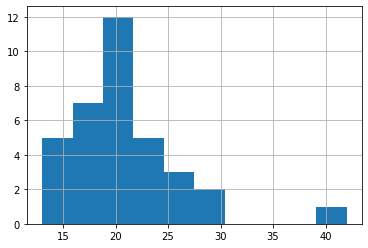

In [35]:
len_sequences = []
for one_seq in jabs_normalised:
    len_sequences.append(len(one_seq))
    
pd.Series(len_sequences).hist()

Here we see that the majority of sequences have length 20, while the longest is 42 (NB this may change). As we want all sequences to be of the same length for training, we will pad the shorter sequences with zeros to simulate landmarks returning to their original positions.

In [36]:
from keras.preprocessing import sequence
max_len = max(len_sequences)

final_seq_jabs=sequence.pad_sequences(jabs_normalised, maxlen=max_len, padding='post', dtype='float')


Next we need to create our label data

In [37]:
jab_data = ["jab"]*20
flipped_data = ["flipped"]*15
label_data = jab_data + flipped_data

And define our training data (here, it is just the jabs data, to be extended for other punches)

In [38]:
final_seq_train = final_seq_jabs

In [39]:
final_seq_train.shape

(35, 42, 30)

In [20]:
import pandas as pd
import numpy as np
from numpy import load
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

Let's create a train/test split using our data

In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(final_seq_train,label_data,test_size = 0.2)

Now we need to encode our labels to be used in training the model

In [41]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)


Now we are ready to define our LSTM model. Using the *Sequential* model structure in Keras, I have built a model with a single LSTM layer followed by a dense layer that classfies the output into two classes.

In [58]:
model = Sequential()
model.add(LSTM(256,activation="relu",input_shape = (42,30),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dense(2,activation="softmax"))

In [23]:
model = Sequential()
model.add(LSTM(256,activation="relu",input_shape = (42,30),return_sequences=False))
model.add(Dense(2,activation="softmax"))

In [59]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [60]:
checkpoint = ModelCheckpoint('weights.hdf5',monitor="val_loss",save_best_only=True)
earlystop = EarlyStopping(monitor="val_accuracy",patience=3,mode="max")
callbackslist = [checkpoint]

In [61]:
training = model.fit(x_train,y_train,epochs=20,batch_size=1,validation_split=0.2,verbose=1,callbacks=callbackslist)
history = training.history

Epoch 1/20
22/22 [==============================] - 3s 86ms/step - loss: 0.6961 - accuracy: 0.5909 - val_loss: 0.7143 - val_accuracy: 0.1667
Epoch 2/20
22/22 [==============================] - 1s 68ms/step - loss: 0.6927 - accuracy: 0.5909 - val_loss: 0.7416 - val_accuracy: 0.1667
Epoch 3/20
22/22 [==============================] - 1s 68ms/step - loss: 0.7267 - accuracy: 0.6364 - val_loss: 0.7772 - val_accuracy: 0.1667
Epoch 4/20
22/22 [==============================] - 1s 67ms/step - loss: 0.7114 - accuracy: 0.5909 - val_loss: 0.3083 - val_accuracy: 1.0000
Epoch 5/20
22/22 [==============================] - 2s 70ms/step - loss: 3.3053 - accuracy: 0.5909 - val_loss: 7.9655 - val_accuracy: 0.1667
Epoch 6/20
22/22 [==============================] - 2s 69ms/step - loss: 2.3223 - accuracy: 0.5909 - val_loss: 2.6930 - val_accuracy: 0.1667
Epoch 7/20
22/22 [==============================] - 2s 68ms/step - loss: 1.0269 - accuracy: 0.3636 - val_loss: 0.7067 - val_accuracy: 0.1667
Epoch 8/20
22

Let's take a look at how the accuracy and loss changes during the training process

Text(0, 0.5, 'Accuracy')

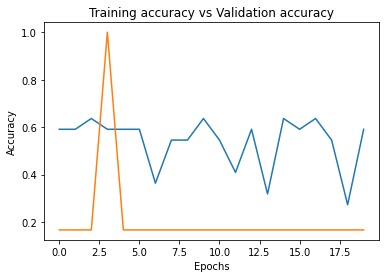

In [62]:
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title('Training accuracy vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Accuracy')

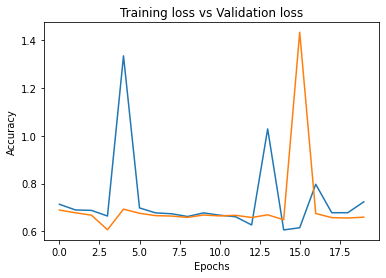

In [262]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title('Training loss vs Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Finally, using the best model from our training data, lets make some predictions on the test data

In [263]:
#Load best model
model.load_weights('weights.hdf5')
#Predict using best model
results = model.evaluate(x_test,y_test,batch_size=1)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 9ms/step - loss: 0.7859 - accuracy: 0.4286
test loss, test acc: [0.785860538482666, 0.4285714328289032]


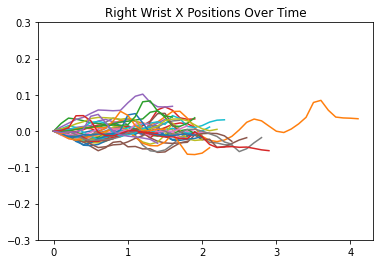

In [394]:
plt.figure()
for jab in csvs:
    jab['right_wrist_x_norm'] = jab['right_wrist_x'] - jab['right_wrist_x'][0]
    plt.plot(jab['timestamp'], jab['right_wrist_x_norm'])
    plt.ylim([-0.3,0.3])
plt.title("Right Wrist X Positions Over Time")
plt.savefig("wrist_pos")

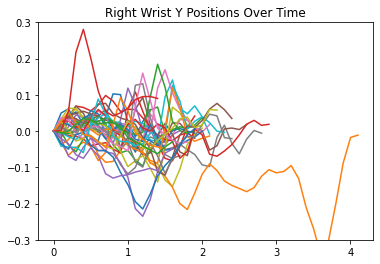

In [395]:
plt.figure()
for jab in csvs:
    jab['right_wrist_y_norm'] = jab['right_wrist_y'] - jab['right_wrist_y'][0]
    plt.plot(jab['timestamp'], jab['right_wrist_y_norm'])
    plt.ylim([-0.3,0.3])
plt.title("Right Wrist Y Positions Over Time")
plt.savefig("wrist_pos")

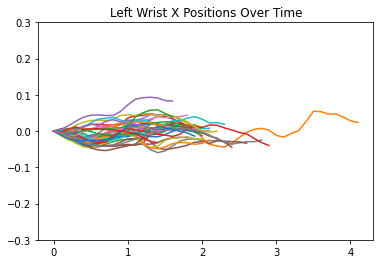

In [396]:
plt.figure()
for jab in csvs:
    jab['left_wrist_x_norm'] = jab['left_wrist_x'] - jab['left_wrist_x'][0]
    plt.plot(jab['timestamp'], jab['left_wrist_x_norm'])
    plt.ylim([-0.3,0.3])

plt.title("Left Wrist X Positions Over Time")
plt.savefig("wrist_pos")

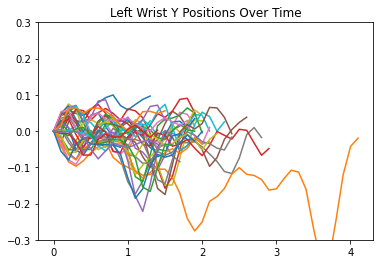

In [397]:
plt.figure()
for jab in csvs:
    jab['left_wrist_y_norm'] = jab['left_wrist_y'] - jab['left_wrist_y'][0]
    plt.plot(jab['timestamp'], jab['left_wrist_y_norm'])
    plt.ylim([-0.3,0.3])

plt.title("Left Wrist Y Positions Over Time")
plt.savefig("wrist_pos")

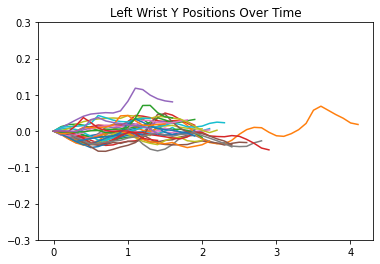

In [398]:
plt.figure()
for jab in csvs:
    jab['left_shoulder_y_norm'] = jab['right_shoulder_x'] - jab['right_shoulder_x'][0]
    plt.plot(jab['timestamp'], jab['left_shoulder_y_norm'])
    plt.ylim([-0.3,0.3])

plt.title("Left Wrist Y Positions Over Time")
plt.savefig("wrist_pos")

In [13]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y 

In [14]:
def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c.y-b.y, c.x-b.x) - math.atan2(a.y-b.y, a.x-b.x))
    return ang

In [15]:
def computeElbowAngle(row, which='right'):
  wrist = Point(row[f'{which}_wrist_x'], row[f'{which}_wrist_y'])
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  return getAngle(wrist, elbow, shoulder)

def computeShoulderAngle(row, which='right'):
  elbow = Point(row[f'{which}_elbow_x'], row[f'{which}_elbow_y'])
  shoulder = Point(row[f'{which}_shoulder_x'], row[f'{which}_shoulder_y'])
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  return getAngle(hip, shoulder, elbow)

def computeKneeAngle(row, which='right'):
  hip = Point(row[f'{which}_hip_x'], row[f'{which}_hip_y'])
  knee = Point(row[f'{which}_knee_x'], row[f'{which}_knee_y'])
  ankle = Point(row[f'{which}_ankle_x'], row[f'{which}_ankle_y'])
  return getAngle(ankle, knee, hip)

In [17]:
# For a single timeslot...
row = annotationsPd.iloc[-1]
print("Elbow angle: " + str(computeElbowAngle(row)))
print("Shoulder angle: " + str(computeShoulderAngle(row)))
#print("Knee angle: " + str(computeKneeAngle(row)))

Elbow angle: 7.050963922596712
Shoulder angle: -5.635284458969723


In [264]:
plt.figure()
for jab in csvs:
    jab['right_elbow_angle'] = jab.apply(computeElbowAngle, axis=1)
    plt.plot(jab['timestamp'], jab['right_elbow_angle'])
plt.title("Right Wrist X Positions Over Time")
plt.savefig("wrist_pos")

NameError: name 'computeElbowAngle' is not defined

<Figure size 432x288 with 0 Axes>

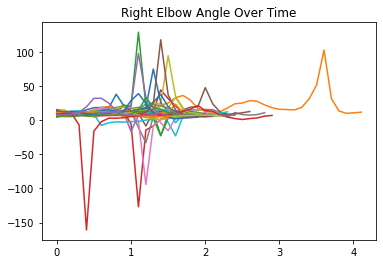

In [387]:
plt.figure()
for jab in csvs:
    jab['right_elbow_angle'] = jab.apply(computeElbowAngle, axis=1)
    plt.plot(jab['timestamp'], jab['right_elbow_angle'])
plt.title("Right Elbow Angle Over Time")
plt.savefig("wrist_pos")

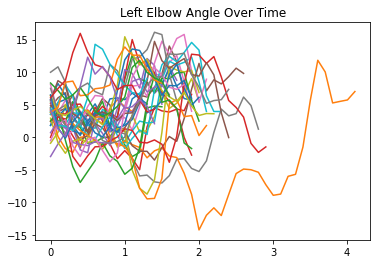

In [388]:
plt.figure()
for jab in csvs:
    jab['left_elbow_angle'] = jab.apply(computeElbowAngle,which='left', axis=1)
    plt.plot(jab['timestamp'], jab['left_elbow_angle'])
plt.title("Left Elbow Angle Over Time")
plt.savefig("wrist_pos")

In [18]:
annotationsPd['right_elbow_angle'] = annotationsPd.apply(computeElbowAngle, axis=1)
annotationsPd['right_shoulder_angle'] = annotationsPd.apply(computeShoulderAngle, axis=1)
#annotationsPd['right_knee_angle'] = annotationsPd.apply(computeKneeAngle, axis=1)

<Figure size 432x288 with 0 Axes>

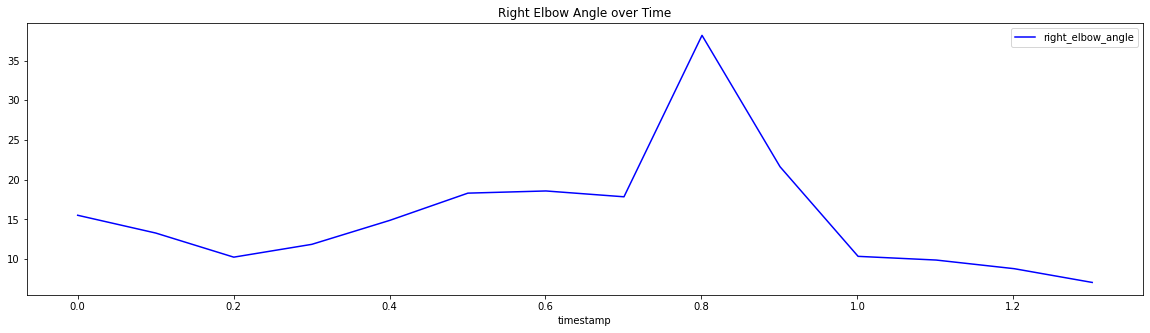

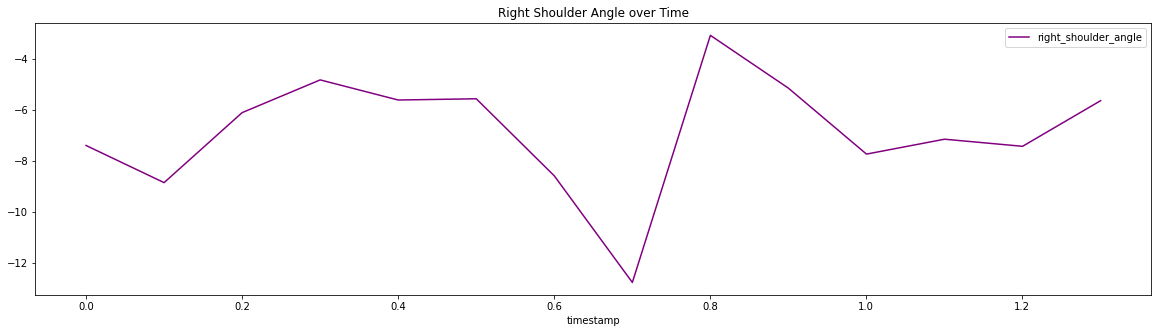

In [19]:
plt.figure()
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), color='blue')
plt.title("Right Elbow Angle over Time")
plt.savefig("right_elbow_angle")
annotationsPd.plot('timestamp', ['right_shoulder_angle'], figsize=(20, 5), color='purple')
plt.title("Right Shoulder Angle over Time")
plt.savefig("right_shoulder_angle")
#annotationsPd.plot('timestamp', ['right_knee_angle'], figsize=(20, 5))
#plt.title("Right Knee Angle over Time")
#plt.savefig("right_knee_angle")

<AxesSubplot:xlabel='right_wrist_y', ylabel='right_elbow_angle'>

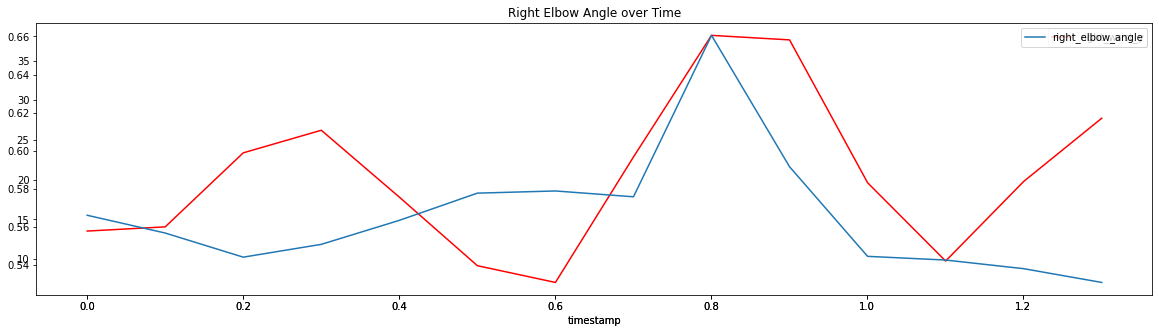

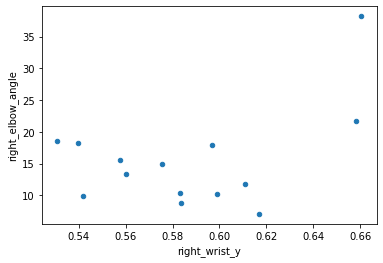

In [21]:
fig = plt.figure()
ax=fig.add_subplot(111, label="1")
annotationsPd.plot('timestamp', ['right_wrist_y'], figsize=(20, 5), ax=ax, color='red')
plt.title("Right Elbow Angle over Time")

ax2=fig.add_subplot(111, label="2", frame_on=False)
annotationsPd.plot('timestamp', ['right_elbow_angle'], figsize=(20, 5), ax=ax2)

annotationsPd.plot.scatter('right_wrist_y', 'right_elbow_angle')